# Dataset

In [21]:
!curl -o /content/drive/MyDrive/click-trough/train.csv.zip -L
!unzip -q /content/drive/MyDrive/click-trough/train.csv.zip

curl: no URL specified!
curl: try 'curl --help' or 'curl --manual' for more information


In [25]:
!curl -o /content/drive/MyDrive/click-trough/test.csv.zip -L
!unzip -q /content/drive/MyDrive/click-trough/test.csv.zip

curl: no URL specified!
curl: try 'curl --help' or 'curl --manual' for more information
replace __MACOSX/._test-2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [26]:
import pandas as pd
import numpy as np
from tqdm import *

In [27]:
chunksize = 10 ** 7
num_of_chunk = 0
train = pd.DataFrame()
lines = pd.read_csv('train-2.csv', chunksize=chunksize)


for chunk in tqdm(lines):
    num_of_chunk = num_of_chunk + 1
    train = pd.concat([train,chunk.sample(frac=0.01)], axis = 0, ignore_index = True)
    # print(f'{str(num_of_chunk)} is done.')

5it [01:38, 19.78s/it]


In [28]:
train_copy = train.copy()

In [29]:
test = pd.read_csv('test-2.csv')
test_copy = test.copy()

In [30]:
submission = pd.read_csv('/content/drive/MyDrive/click-trough/submission.csv')

In [31]:
print('Train dataset:',train.shape)
print('Test dataset:',test.shape)
print('Submission:',submission.shape)

Train dataset: (404290, 24)
Test dataset: (4577464, 23)
Submission: (4577464, 2)


In [32]:
train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.575549e+19,1,14102202,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,21760,320,50,2502,0,35,-1,221
1,4.319910e+18,1,14102206,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,0,21678,320,50,2495,2,167,100173,23
2,1.350724e+19,0,14102211,1005,0,85f751fd,c4e18dd6,50e219e0,d1b126bb,47464e95,...,1,0,787,320,50,153,0,169,100094,20
3,3.806209e+18,1,14102209,1005,0,85f751fd,c4e18dd6,50e219e0,54c5d545,2347f47a,...,1,0,16688,320,50,1873,3,39,100039,23
4,9.010508e+18,1,14102212,1005,0,5bcf81a2,9d54950b,f028772b,ecad2386,7801e8d9,...,1,0,21768,320,50,2506,0,35,100111,157


# preprocessing time

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [34]:
train['hour'] = pd.to_datetime(train['hour'], format = '%y%m%d%H')

<Axes: >

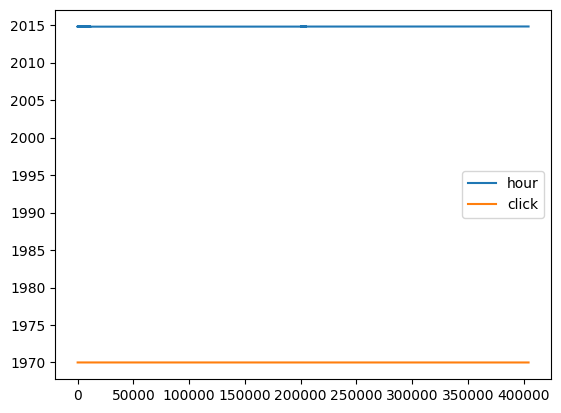

In [35]:
train[['hour', 'click']].plot()

<Axes: xlabel='hour', ylabel='count'>

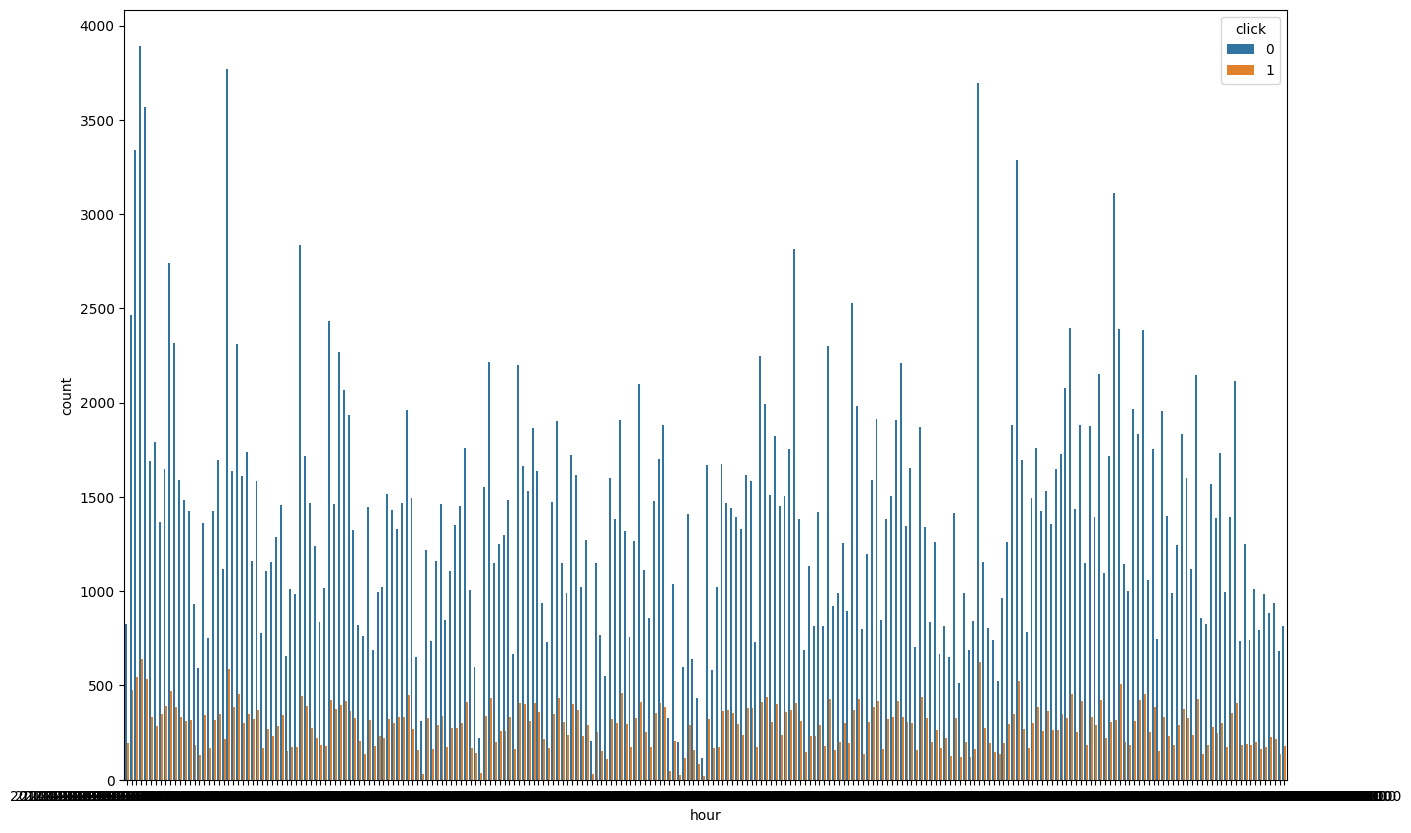

In [36]:
plt.figure(figsize=(15,10))
sns.countplot(x='hour',hue='click',data=train)

In [37]:
train['month'] = train['hour'].dt.month
train['dayofweek'] = train['hour'].dt.dayofweek
train['day'] = train['hour'].dt.day
train['hour_time'] = train['hour'].dt.hour

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 28 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                404290 non-null  float64       
 1   click             404290 non-null  int64         
 2   hour              404290 non-null  datetime64[ns]
 3   C1                404290 non-null  int64         
 4   banner_pos        404290 non-null  int64         
 5   site_id           404290 non-null  object        
 6   site_domain       404290 non-null  object        
 7   site_category     404290 non-null  object        
 8   app_id            404290 non-null  object        
 9   app_domain        404290 non-null  object        
 10  app_category      404290 non-null  object        
 11  device_id         404290 non-null  object        
 12  device_ip         404290 non-null  object        
 13  device_model      404290 non-null  object        
 14  devi

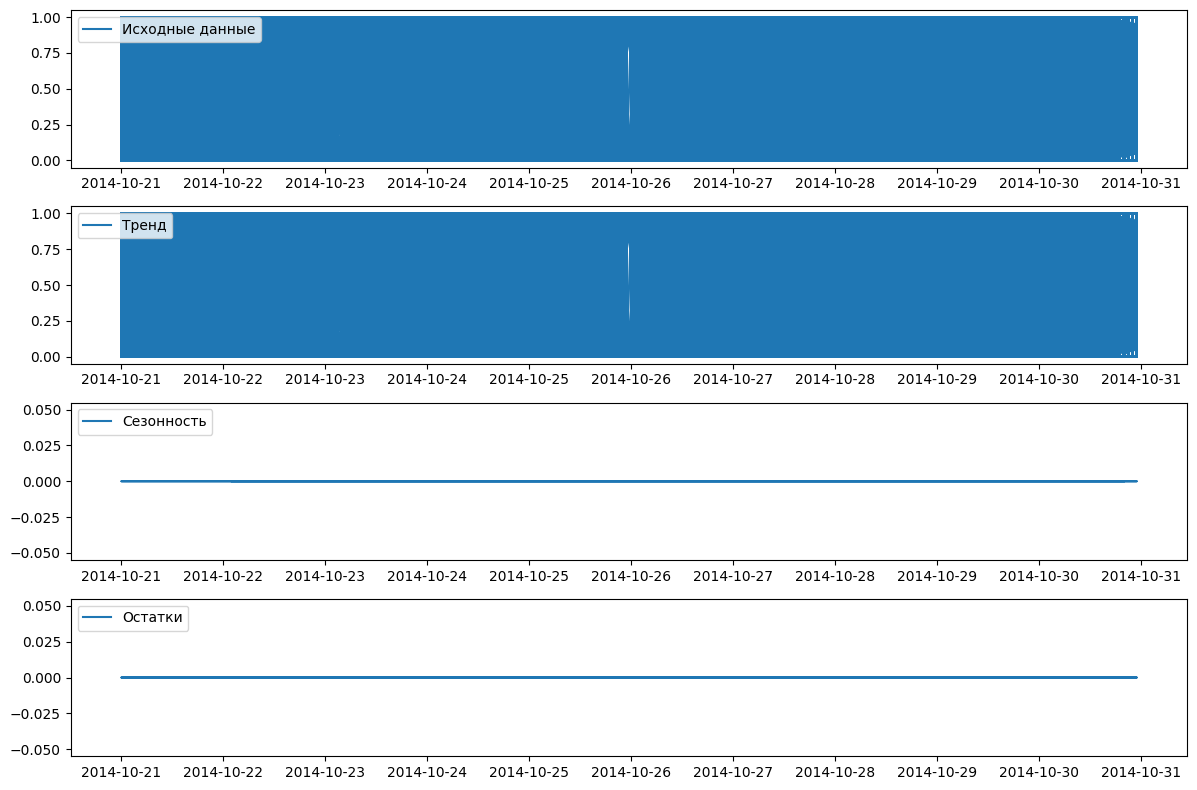

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Предположим, что у вас есть DataFrame 'train' с временной колонкой 'hour' и столбцом 'click'
# Пример:
# train = ваш DataFrame
# Установите столбец 'hour' в качестве индекса
train.set_index('hour', inplace=True)

# Произведите декомпозицию временного ряда
result = seasonal_decompose(train['click'], model='additive', extrapolate_trend='freq', period=1)

# Получите компоненты: тренд, сезонность и остатки
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Визуализация компонентов
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(train['click'], label='Исходные данные')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Тренд')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal, label='Сезонность')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Остатки')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Encoder, Scaler

In [40]:
num = []
cat = []

for col in train.columns:
    if train[col].dtype == "object":
        cat.append(col)
    else:
        num.append(col)
print("num columns = ", num)
print("cat columns = ", cat)

num columns =  ['id', 'click', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'month', 'dayofweek', 'day', 'hour_time']
cat columns =  ['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model']


In [41]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.7 MB/s eta 0:00:00


In [42]:
import category_encoders as ce

In [43]:
X = train.drop(['click'], axis=1)
y = train['click']

In [44]:
target_encoder = ce.TargetEncoder()
X = target_encoder.fit_transform(X, y)

In [45]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = X.copy()
X_train_scaled[X.columns] = scaler.fit_transform(X[X.columns])
X_train_scaled.head()

,id,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,...,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour_time
hour,,,,,,,,,,,,,,,,,,,,,
2014-10-22 02:00:00,0.854106,0.363636,0.000000,0.250754,0.308026,0.426427,0.209037,0.301242,0.680367,0.202167,...,0.02988,0.903592,0.000000,0.001107,0.000000,0.866142,0.0,0.333333,0.111111,0.086957
2014-10-22 06:00:00,0.234174,0.363636,0.142857,0.355317,0.381530,0.362150,0.209037,0.301242,0.680367,0.202167,...,0.02988,0.900945,0.666667,0.074197,0.999252,0.086614,0.0,0.333333,0.111111,0.260870
2014-10-22 11:00:00,0.732226,0.363636,0.000000,0.143908,0.182854,0.259171,0.057271,0.081008,0.487993,0.060708,...,0.02988,0.015501,0.000000,0.075305,0.998464,0.074803,0.0,0.333333,0.111111,0.478261
2014-10-22 09:00:00,0.206326,0.363636,0.000000,0.143908,0.182854,0.259171,0.129601,0.213305,0.309390,0.202167,...,0.02988,0.665784,1.000000,0.003322,0.997915,0.086614,0.0,0.333333,0.111111,0.391304
2014-10-22 12:00:00,0.488455,0.363636,0.000000,0.141628,0.168725,0.362150,0.209037,0.301242,0.680367,0.202167,...,0.02988,0.905104,0.000000,0.001107,0.998633,0.614173,0.0,0.333333,0.111111,0.521739


In [46]:
matrix = X.copy()

In [47]:
matrix['click'] = y

In [48]:
matrix.head()

,id,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,...,C17,C18,C19,C20,C21,month,dayofweek,day,hour_time,click
hour,,,,,,,,,,,,,,,,,,,,,
2014-10-22 02:00:00,1.575549e+19,1005,0,0.206382,0.206382,0.208645,0.198187,0.194411,0.198648,0.173559,...,2502,0,35,-1,221,10,2,22,2,1
2014-10-22 06:00:00,4.319910e+18,1005,1,0.292442,0.255631,0.177943,0.198187,0.194411,0.198648,0.173559,...,2495,2,167,100173,23,10,2,22,6,1
2014-10-22 11:00:00,1.350724e+19,1005,0,0.118443,0.122515,0.128756,0.054298,0.054298,0.151986,0.055945,...,153,0,169,100094,20,10,2,22,11,0
2014-10-22 09:00:00,3.806209e+18,1005,0,0.118443,0.122515,0.128756,0.122874,0.138466,0.108665,0.173559,...,1873,3,39,100039,23,10,2,22,9,1
2014-10-22 12:00:00,9.010508e+18,1005,0,0.116566,0.113048,0.177943,0.198187,0.194411,0.198648,0.173559,...,2506,0,35,100111,157,10,2,22,12,1


<ipython-input-49-659b9c65f998>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(), annot = True)


<Axes: >

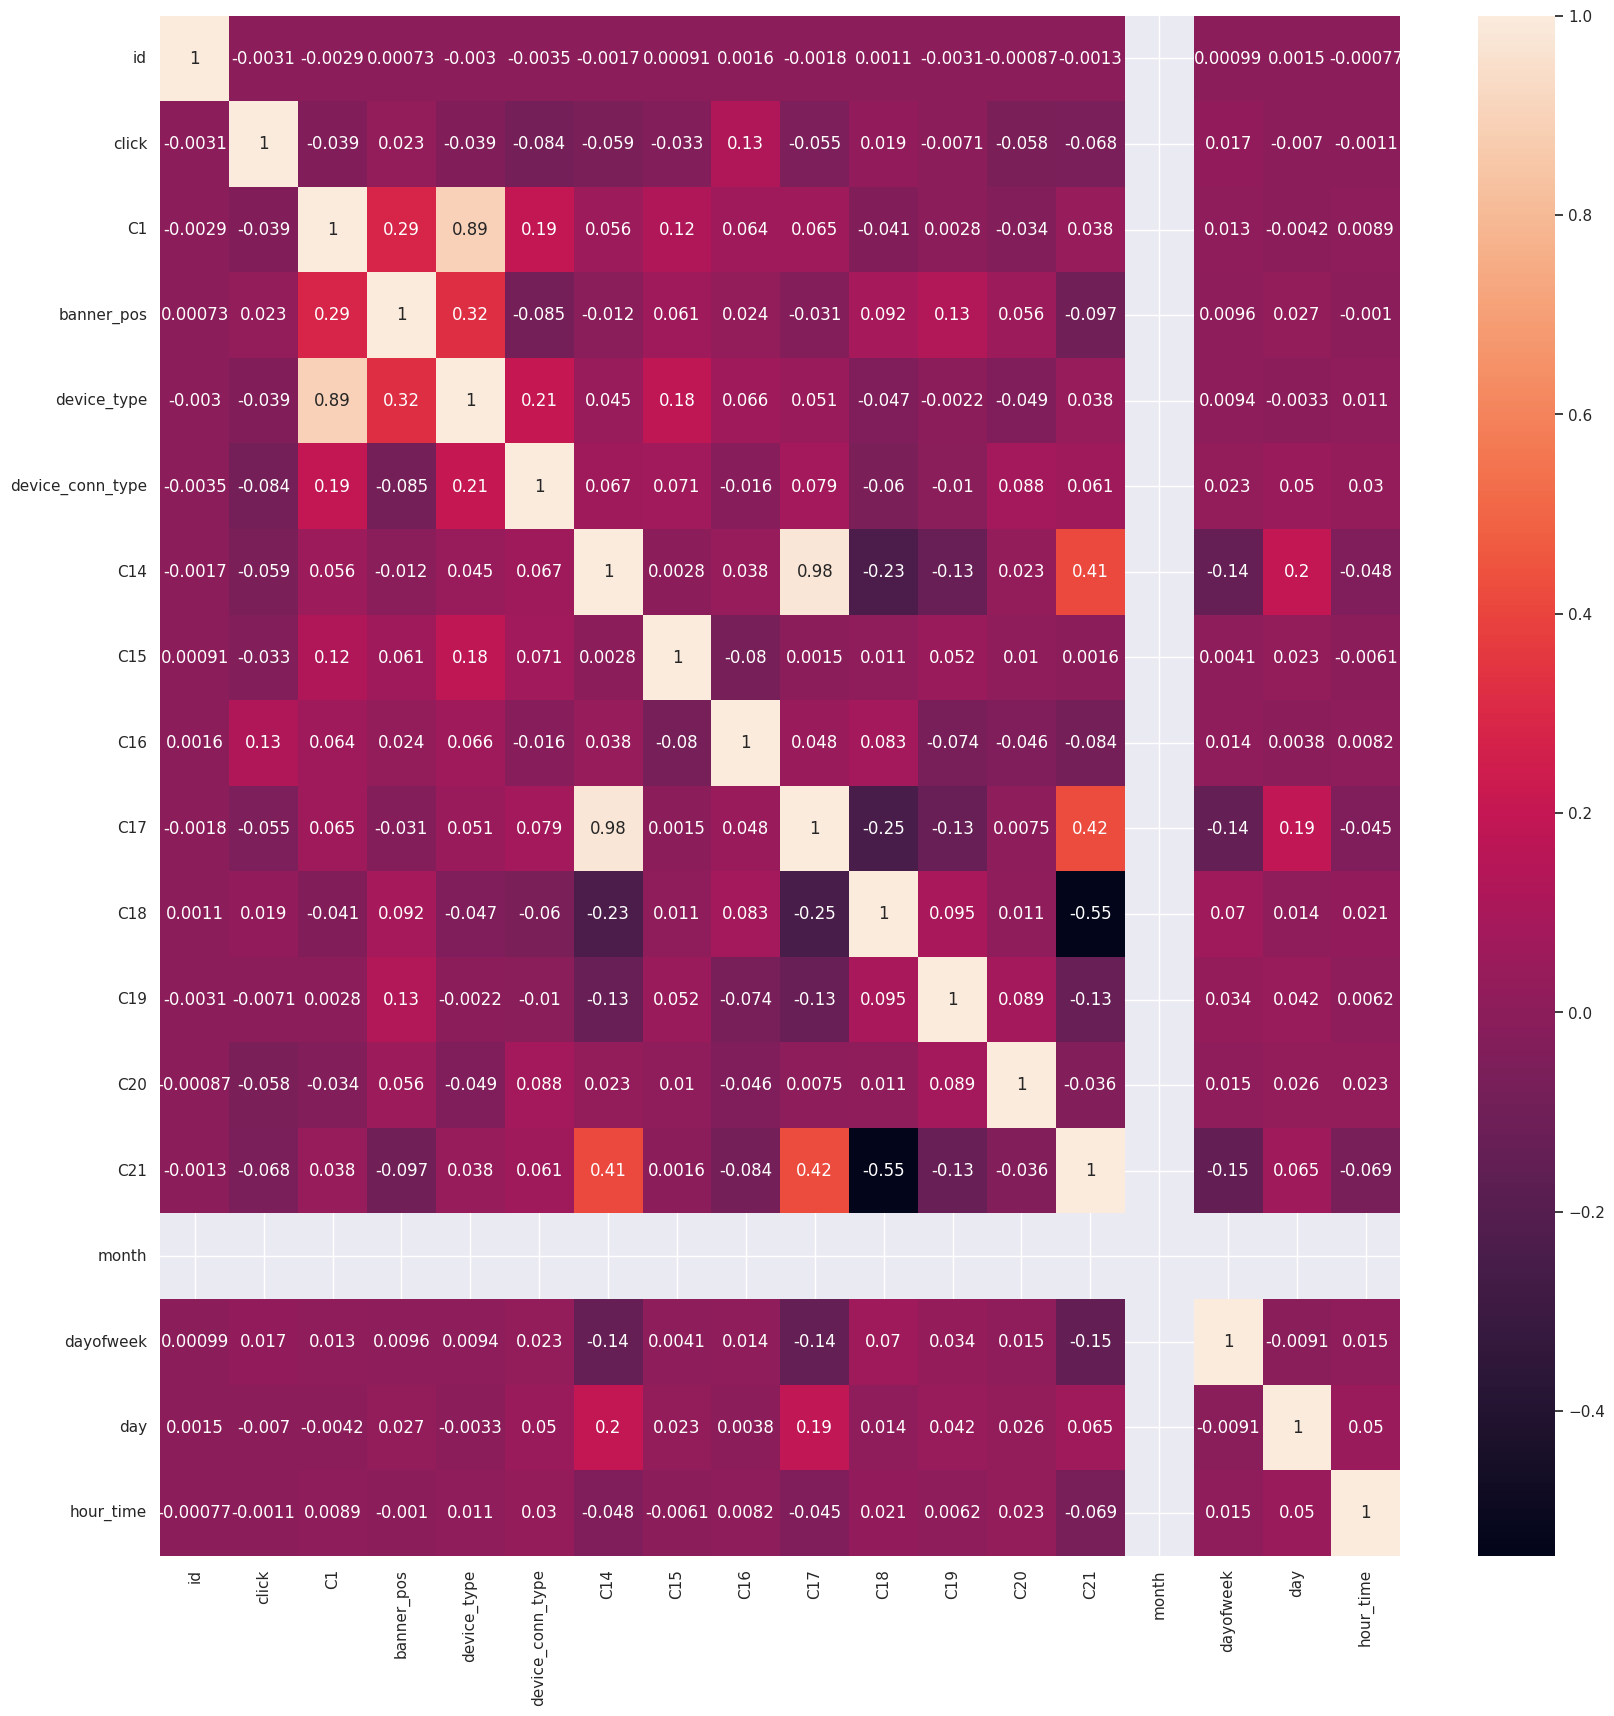

In [49]:
sns.set(rc={'figure.figsize': (20, 20)})
sns.heatmap(train.corr(), annot = True)

In [50]:
X = X.drop(['id', 'month'], axis=1)

# Балансировка

In [51]:
from imblearn.over_sampling import RandomOverSampler
random_sample = RandomOverSampler()
x_new, y_new = random_sample.fit_resample(X, y)

# PCA (nmds, tsne)

In [52]:
from sklearn.decomposition import PCA

In [53]:
n_components = 7
fa = PCA(n_components=n_components)

In [54]:
X_fa = fa.fit_transform(x_new)

In [55]:
X_fa = pd.DataFrame(fa.components_, columns=train.drop(['click', 'id', 'month'], axis=1).columns)

In [56]:
X_fa

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,...,C15,C16,C17,C18,C19,C20,C21,dayofweek,day,hour_time
0,9.762049e-07,-6.235727e-07,2.095219e-07,1.864965e-07,6.659242e-08,1.934082e-07,1.227677e-07,8.909985e-08,-1.939913e-08,1.403821e-07,...,-0.000005,0.000056,0.000176,2.244661e-07,-0.000644,-9.999998e-01,0.000015,-2.272527e-07,-0.000001,-0.000002
1,-1.036504e-05,1.599342e-06,1.010075e-06,8.784844e-07,6.027536e-09,1.034338e-06,7.927031e-07,-9.606875e-08,3.798874e-07,9.800345e-07,...,0.000021,-0.000608,-0.119174,6.046210e-05,0.009272,9.094320e-05,-0.005447,4.502119e-05,-0.000112,0.000057
2,3.413594e-05,1.918575e-04,-2.875432e-05,-2.675179e-05,-1.299706e-05,-4.178532e-06,-6.996579e-06,-5.649237e-06,1.115511e-05,-7.182076e-06,...,0.003753,-0.014858,0.009174,2.407222e-04,0.999681,-6.447008e-04,-0.015781,2.669376e-05,0.000423,0.000048
3,-4.140402e-04,3.508779e-04,-1.734281e-05,-2.464729e-05,4.585724e-06,1.881374e-05,1.967738e-05,2.326329e-05,-3.135175e-06,-5.568116e-06,...,0.002442,-0.032561,-0.989838,1.025996e-03,0.006493,-1.956307e-04,-0.069874,6.913140e-04,0.000461,-0.000700
4,3.975853e-04,6.225326e-04,6.440832e-04,6.353381e-04,1.659760e-04,8.136446e-05,3.367156e-05,5.355478e-05,1.613304e-05,9.239996e-05,...,-0.025364,0.474994,0.046145,9.613872e-03,-0.007128,2.627308e-05,-0.878306,2.428504e-03,0.001277,0.005712
5,1.282260e-03,-3.666280e-04,8.239837e-04,8.643951e-04,2.914930e-04,8.018042e-05,7.293583e-05,3.018192e-05,-1.722649e-05,9.307683e-05,...,-0.042092,0.877880,-0.061663,-3.933109e-03,0.021195,3.107803e-05,0.472500,-9.083335e-04,-0.000565,-0.002619
6,6.906877e-03,2.203937e-03,-5.929535e-04,-5.671112e-04,-1.955409e-04,-9.168435e-05,-7.144125e-05,-1.571133e-04,1.049044e-05,-5.742375e-05,...,0.998735,0.049182,0.000961,7.610825e-04,-0.003062,-4.191587e-07,-0.002156,5.776408e-04,0.003026,-0.000702


In [57]:
fa.explained_variance_ratio_

array([9.89641097e-01, 1.02999564e-02, 4.96828171e-05, 6.27299076e-06,
       1.70057858e-06, 1.12273078e-06, 1.47978681e-07])

In [58]:
x_new_fa = pd.DataFrame(fa.transform(x_new), columns=fa.get_feature_names_out())

In [59]:
x_new_fa.shape

(671644, 7)

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_new_fa, y_new, stratify=y_new, test_size=0.3, random_state=42)

# Catboost

In [61]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 18.4 MB/s eta 0:00:00


In [62]:
from catboost import CatBoostClassifier

In [63]:
model_cat = CatBoostClassifier(
    iterations=5000,
    verbose=1000,
    learning_rate=0.005,
    l2_leaf_reg=0.03,
    depth=7,
    leaf_estimation_method='Newton',
    leaf_estimation_iterations=65,
    use_best_model=True,
    task_type="GPU",
    devices='0:1'
)

In [64]:
model_cat.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 0.6927239	test: 0.6927270	best: 0.6927270 (0)	total: 21.6ms	remaining: 1m 48s
1000:	learn: 0.6364608	test: 0.6378704	best: 0.6378704 (1000)	total: 18.8s	remaining: 1m 15s
2000:	learn: 0.6305826	test: 0.6325102	best: 0.6325102 (2000)	total: 37.9s	remaining: 56.8s
3000:	learn: 0.6273981	test: 0.6297298	best: 0.6297298 (3000)	total: 56.7s	remaining: 37.7s
4000:	learn: 0.6251755	test: 0.6278665	best: 0.6278665 (4000)	total: 1m 15s	remaining: 18.9s
4999:	learn: 0.6234991	test: 0.6264942	best: 0.6264942 (4999)	total: 1m 34s	remaining: 0us
bestTest = 0.6264941512
bestIteration = 4999


# SGDClassifier

In [70]:
from sklearn.linear_model import SGDClassifier

In [71]:
model_sgd = SGDClassifier(
    loss='log_loss',
    penalty='l2',
    n_iter_no_change=80,
    shuffle=True,
    max_iter=10000,
    warm_start=True
)

In [72]:
model_sgd.partial_fit(X_train, y_train, classes=np.unique(y_train))

SGDClassifier(loss='log_loss', max_iter=10000, n_iter_no_change=80,
              warm_start=True)

In [73]:
from sklearn.metrics import log_loss

In [75]:
pretict_val = model_sgd.predict_proba(X_test)

In [77]:
log_loss(y_test, pretict_val)

19.394567302755764

# FastFM

In [78]:
!pip install fastFM

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastFM: filename=fastFM-0.2.10-cp310-cp310-linux_x86_64.whl size=591476 sha256=c33fa5daa10974c335fbf9a494b99a53a33a7df2db31ddf3499dabd01eaf6f21
  Stored in directory: /root/.cache/pip/wheels/93/92/52/2da7997fcb7a7ce9042ff3b33836ef0c2fd47aa95382d7a113
Successfully built fastFM


In [88]:
from fastFM import als
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import DictVectorizer

In [89]:
vectorizer = DictVectorizer()

In [90]:
X_sparse = vectorizer.fit_transform(X_train.to_dict(orient='records'))

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.FMClassifier.html

In [93]:
model_fm = als.FMRegression(
    n_iter=2000,
    init_stdev=0.1,
    rank=2,
    l2_reg_w=0.1,
    l2_reg_V=0.5)

In [94]:
model_fm.fit(X_sparse, y_train)

FMRegression(l2_reg_V=0.5, n_iter=2000, rank=2)

In [104]:
X_test_parse = vectorizer.fit_transform(X_test.to_dict(orient='records'))

In [105]:
predict = model_fm.predict(X_test_parse)

In [113]:
len(predict)

201494

In [108]:
len(y_test)

201494

In [114]:
log_loss(predict.tolist(), y_test)

ValueError: ignored

# Test


In [115]:
test.head()

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000017e+19,14103100,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,...,1,0,8330,320,50,761,3,175,100075,23
1,1.000018e+19,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,22676,320,50,2616,0,35,100083,51
2,1.000055e+19,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,22676,320,50,2616,0,35,100083,51
3,1.000109e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,0f2161f8,...,1,0,18648,320,50,1092,3,809,100156,61
4,1.000138e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,...,1,0,23160,320,50,2667,0,47,-1,221


In [180]:
test = test_copy.copy()

In [181]:
test['hour'] = pd.to_datetime(test['hour'], format = '%y%m%d%H')

In [182]:
test['month'] = test['hour'].dt.month
test['dayofweek'] = test['hour'].dt.dayofweek
test['day'] = test['hour'].dt.day
test['hour_time'] = test['hour'].dt.hour

In [183]:
test


,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour_time
0,1.000017e+19,2014-10-31 00:00:00,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,...,50,761,3,175,100075,23,10,4,31,0
1,1.000018e+19,2014-10-31 00:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,50,2616,0,35,100083,51,10,4,31,0
2,1.000055e+19,2014-10-31 00:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,50,2616,0,35,100083,51,10,4,31,0
3,1.000109e+19,2014-10-31 00:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,0f2161f8,...,50,1092,3,809,100156,61,10,4,31,0
4,1.000138e+19,2014-10-31 00:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,...,50,2667,0,47,-1,221,10,4,31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4577459,9.998167e+18,2014-10-31 23:00:00,1005,0,93eaba74,7687a86e,3e814130,ecad2386,7801e8d9,07d7df22,...,250,1994,2,39,-1,33,10,4,31,23
4577460,9.998250e+18,2014-10-31 23:00:00,1005,0,17d1b03f,f3845767,f028772b,ecad2386,7801e8d9,07d7df22,...,50,2545,0,431,100084,221,10,4,31,23
4577461,9.998802e+16,2014-10-31 23:00:00,1005,0,5b08c53b,7687a86e,3e814130,ecad2386,7801e8d9,07d7df22,...,250,1994,2,39,-1,33,10,4,31,23
4577462,9.999087e+18,2014-10-31 23:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,92f5800b,ae637522,0f2161f8,...,50,2734,1,175,100189,71,10,4,31,23


In [184]:
test = test.drop('hour', axis=1)

In [185]:
test


,id,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,...,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour_time
0,1.000017e+19,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,...,50,761,3,175,100075,23,10,4,31,0
1,1.000018e+19,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,...,50,2616,0,35,100083,51,10,4,31,0
2,1.000055e+19,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,...,50,2616,0,35,100083,51,10,4,31,0
3,1.000109e+19,1005,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,0f2161f8,a99f214a,...,50,1092,3,809,100156,61,10,4,31,0
4,1.000138e+19,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,a99f214a,...,50,2667,0,47,-1,221,10,4,31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4577459,9.998167e+18,1005,0,93eaba74,7687a86e,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,...,250,1994,2,39,-1,33,10,4,31,23
4577460,9.998250e+18,1005,0,17d1b03f,f3845767,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,...,50,2545,0,431,100084,221,10,4,31,23
4577461,9.998802e+16,1005,0,5b08c53b,7687a86e,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,...,250,1994,2,39,-1,33,10,4,31,23
4577462,9.999087e+18,1005,0,85f751fd,c4e18dd6,50e219e0,92f5800b,ae637522,0f2161f8,a99f214a,...,50,2734,1,175,100189,71,10,4,31,23


In [186]:
test = target_encoder.transform(test)

In [187]:
test


,id,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,...,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour_time
0,1.000017e+19,1005,0,0.120267,0.120614,0.177943,0.198187,0.194411,0.198648,0.173559,...,50,761,3,175,100075,23,10,4,31,0
1,1.000018e+19,1005,0,0.206382,0.206382,0.208645,0.198187,0.194411,0.198648,0.173559,...,50,2616,0,35,100083,51,10,4,31,0
2,1.000055e+19,1005,0,0.206382,0.206382,0.208645,0.198187,0.194411,0.198648,0.173559,...,50,2616,0,35,100083,51,10,4,31,0
3,1.000109e+19,1005,0,0.118443,0.122515,0.128756,0.042271,0.062313,0.108665,0.173559,...,50,1092,3,809,100156,61,10,4,31,0
4,1.000138e+19,1005,0,0.118443,0.122515,0.128756,0.307764,0.138466,0.249168,0.173559,...,50,2667,0,47,-1,221,10,4,31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4577459,9.998167e+18,1005,0,0.472687,0.459813,0.282210,0.198187,0.194411,0.198648,0.173559,...,250,1994,2,39,-1,33,10,4,31,23
4577460,9.998250e+18,1005,0,0.169354,0.206382,0.177943,0.198187,0.194411,0.198648,0.173559,...,50,2545,0,431,100084,221,10,4,31,23
4577461,9.998802e+16,1005,0,0.463687,0.459813,0.282210,0.198187,0.194411,0.198648,0.173559,...,250,1994,2,39,-1,33,10,4,31,23
4577462,9.999087e+18,1005,0,0.118443,0.122515,0.128756,0.020478,0.025337,0.108665,0.173559,...,50,2734,1,175,100189,71,10,4,31,23


In [188]:
test[test.columns] = scaler.transform(test[test.columns])

In [189]:
test

,id,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,...,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour_time
0,0.542106,0.363636,0.0,0.146125,0.180017,0.362150,0.209037,0.301242,0.680367,0.202167,...,0.029880,0.245369,1.000000,0.078627,0.998274,0.086614,0.0,0.666667,1.111111,0.0
1,0.542106,0.363636,0.0,0.250754,0.308026,0.426427,0.209037,0.301242,0.680367,0.202167,...,0.029880,0.946692,0.000000,0.001107,0.998354,0.196850,0.0,0.666667,1.111111,0.0
2,0.542126,0.363636,0.0,0.250754,0.308026,0.426427,0.209037,0.301242,0.680367,0.202167,...,0.029880,0.946692,0.000000,0.001107,0.998354,0.196850,0.0,0.666667,1.111111,0.0
3,0.542156,0.363636,0.0,0.143908,0.182854,0.259171,0.044585,0.093605,0.309390,0.202167,...,0.029880,0.370510,1.000000,0.429679,0.999082,0.236220,0.0,0.666667,1.111111,0.0
4,0.542171,0.363636,0.0,0.143908,0.182854,0.259171,0.324612,0.213305,0.888650,0.202167,...,0.029880,0.965974,0.000000,0.007752,0.000000,0.866142,0.0,0.666667,1.111111,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4577459,0.541997,0.363636,0.0,0.574314,0.686273,0.580445,0.209037,0.301242,0.680367,0.202167,...,0.229084,0.711531,0.666667,0.003322,0.000000,0.125984,0.0,0.666667,1.111111,1.0
4577460,0.542001,0.363636,0.0,0.205765,0.308026,0.362150,0.209037,0.301242,0.680367,0.202167,...,0.029880,0.919849,0.000000,0.220377,0.998364,0.866142,0.0,0.666667,1.111111,1.0
4577461,0.005409,0.363636,0.0,0.563380,0.686273,0.580445,0.209037,0.301242,0.680367,0.202167,...,0.229084,0.711531,0.666667,0.003322,0.000000,0.125984,0.0,0.666667,1.111111,1.0
4577462,0.542047,0.363636,0.0,0.143908,0.182854,0.259171,0.021599,0.035486,0.309390,0.202167,...,0.029880,0.991304,0.333333,0.078627,0.999411,0.275591,0.0,0.666667,1.111111,1.0


In [190]:
test = test.drop(['id', 'month'], axis=1)

In [193]:
test = pd.DataFrame(fa.transform(test), columns=fa.get_feature_names_out())

In [194]:
test

,pca0,pca1,pca2,pca3,pca4,pca5,pca6
0,50718.386511,18681.972714,-364.184744,-139.123777,-29.737113,-43.712525,-326.376527
1,50718.386534,18681.285976,-364.252743,-139.754910,-29.811128,-43.698472,-326.376839
2,50718.386534,18681.285976,-364.252743,-139.754910,-29.811125,-43.698467,-326.376855
3,50718.385449,18681.527425,-363.831380,-139.203839,-29.865781,-43.640251,-326.377696
4,50719.384895,18681.259700,-364.255664,-139.818075,-30.398332,-43.383450,-326.378173
...,...,...,...,...,...,...,...
4577459,50719.384879,18681.524954,-364.255549,-139.548858,-29.651754,-43.547160,-326.389864
4577460,50718.386390,18681.311613,-364.044503,-139.777265,-30.396074,-43.378710,-326.379656
4577461,50719.384879,18681.524953,-364.255548,-139.548859,-29.651774,-43.547185,-326.389812
4577462,50718.385428,18681.231481,-364.175515,-139.798732,-29.870510,-43.666379,-326.375674


## Catboost test

In [195]:
sumbission = pd.read_csv('/content/drive/MyDrive/click-trough/submission.csv')

In [210]:
submission['click'] = model_cat.predict(test)

In [211]:
submission[submission['click'] < 0.5]

,id,click
0,1.000017e+19,0
1,1.000018e+19,0
2,1.000055e+19,0
3,1.000109e+19,0
4,1.000138e+19,0
...,...,...
4577459,9.998167e+18,0
4577460,9.998250e+18,0
4577461,9.998802e+16,0
4577462,9.999087e+18,0


In [212]:
submission.to_csv('/content/drive/MyDrive/click-trough/submision_cat.csv', index=False)

## SGDClassifier test

In [169]:
submission['click'] = model_sgd.predict(test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [170]:
submission

,id,click
0,1.000017e+19,0
1,1.000018e+19,0
2,1.000055e+19,0
3,1.000109e+19,0
4,1.000138e+19,0
...,...,...
4577459,9.998167e+18,0
4577460,9.998250e+18,0
4577461,9.998802e+16,0
4577462,9.999087e+18,0


In [172]:
submission.to_csv('/content/drive/MyDrive/click-trough/submision_sgd.csv', index=False)

## FastFm test

In [176]:
test

array([[ 5.07183865e+04,  1.86819727e+04, -3.64184744e+02, ...,
        -2.97371128e+01, -4.37125246e+01, -3.26376527e+02],
       [ 5.07183865e+04,  1.86812860e+04, -3.64252743e+02, ...,
        -2.98111285e+01, -4.36984721e+01, -3.26376839e+02],
       [ 5.07183865e+04,  1.86812860e+04, -3.64252743e+02, ...,
        -2.98111247e+01, -4.36984672e+01, -3.26376855e+02],
       ...,
       [ 5.07193849e+04,  1.86815250e+04, -3.64255548e+02, ...,
        -2.96517743e+01, -4.35471850e+01, -3.26389812e+02],
       [ 5.07183854e+04,  1.86812315e+04, -3.64175515e+02, ...,
        -2.98705098e+01, -4.36663793e+01, -3.26375674e+02],
       [ 5.07183864e+04,  1.86813053e+04, -3.64044451e+02, ...,
        -3.03960831e+01, -4.33786858e+01, -3.26379632e+02]])

In [199]:
test_parse = vectorizer.transform(test.to_dict(orient='records'))

In [202]:
submission['click'] = model_fm.predict(test_parse)

In [206]:
submission['click'].unique()

array([0.73748549, 0.73714308, 0.73714311, ..., 0.73667922, 0.73718283,
       0.73790161])

In [209]:
submission.to_csv('/content/drive/MyDrive/click-trough/submision_fast-fm.csv', index=False)

Id - может поднять скор